### Importowanie biblotek

In [59]:
import pandas as pd

# Modelowanie danych
import seaborn as sns
import matplotlib.pyplot as plt

### Pobranie danych i wstępna analiza ich jakości

In [60]:
file = "../raw_data/openfoodfacts_data.csv"
df = pd.read_csv(file, on_bad_lines='skip', low_memory=False, sep=';')
full_df = df.copy()
df.head(5)

,product_name,categories_en,ingredients_text,energy-kcal_100g,sugars_100g,saturated-fat_100g,fat_100g,salt_100g,fiber_100g,proteins_100g,nutriscore_grade,food_groups_en,main_category_en,countries_en
0,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,48.0,6.40,0.4,0.6,0.09,0.800000,2.0,b,NaN,Clean-antioxidant-energy-drink,"France,Germany,United States"
1,California Whole Pitted Prunes,"Beverages and beverages preparations,Beverages...","california dried pitted plums, potassium sorbate",250.0,37.50,0.0,0.0,0.00,7.500000,2.5,c,"Beverages,Unsweetened beverages",Sample,Germany
2,NaN,"Beverages and beverages preparations,Plant-bas...","Jus et purée d'abricots (50%), eau, sucre.",208.0,8.00,0.0,0.0,0.23,88.000000,0.0,e,"Beverages,Sweetened beverages",Vegetables,"France,Germany"
3,NaN,"Beverages and beverages preparations,Beverages...",NaN,230.0,0.98,2.0,11.0,0.95,9.000000,22.0,c,NaN,Cinnamon-roll,"Germany,United States"
4,Aberfeldy 12 years,"Beverages and beverages preparations,Beverages...","Sojaproteinisolat, Weizen - protein, Kaffee-Ex...",358.0,1.70,0.5,2.0,1.50,10.714286,76.0,not-applicable,"Beverages,Artificially sweetened beverages",Protein,"Germany,United States"


In [61]:
df.isnull().sum()

product_name           10974
categories_en         410515
ingredients_text      480007
energy-kcal_100g           0
sugars_100g                0
saturated-fat_100g         0
fat_100g                   0
salt_100g                  0
fiber_100g                 0
proteins_100g              0
nutriscore_grade           0
food_groups_en        532595
main_category_en      410516
countries_en            3128
dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037983 entries, 0 to 1037982
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   product_name        1027009 non-null  object 
 1   categories_en       627468 non-null   object 
 2   ingredients_text    557976 non-null   object 
 3   energy-kcal_100g    1037983 non-null  float64
 4   sugars_100g         1037983 non-null  float64
 5   saturated-fat_100g  1037983 non-null  float64
 6   fat_100g            1037983 non-null  float64
 7   salt_100g           1037983 non-null  float64
 8   fiber_100g          1037983 non-null  float64
 9   proteins_100g       1037983 non-null  float64
 10  nutriscore_grade    1037983 non-null  object 
 11  food_groups_en      505388 non-null   object 
 12  main_category_en    627467 non-null   object 
 13  countries_en        1034855 non-null  object 
dtypes: float64(7), object(7)
memory usage: 110.9+ MB


#### Sprawdzenie czy dane mają ujemne wartości

In [63]:
numerical_columns = df[["energy-kcal_100g", "sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g", "proteins_100g", 'fat_100g']].copy()

if (numerical_columns < 0).any().any():
    print("Brak ujemnych wartości")
else:
    print("Ujemne wartości występują w danych")

Brak ujemnych wartości


#### Oczyszczanie danych

In [64]:
df["nutriscore_grade"].value_counts()


nutriscore_grade
unknown           422080
e                 154407
d                 151016
c                 134363
a                 101721
b                  66018
not-applicable      8378
Name: count, dtype: int64

##### oczyszczanie danych - pozbycie sie non-applicable

In [65]:
#Pozbywamy sie wartości not-applicable bo sa to produkty typu alkohol, papierosy
df = df[df["nutriscore_grade"] != "not-applicable"]

df["nutriscore_grade"].value_counts()

nutriscore_grade
unknown    422080
e          154407
d          151016
c          134363
a          101721
b           66018
Name: count, dtype: int64

In [66]:
df["countries_en"] = df["countries_en"].fillna("").astype(str).str.split(",").apply(
    lambda x: [country.strip() for country in x if country.strip()]
)
df = df.explode("countries_en").reset_index(drop=True)

##### oczyszczanie danych - kraje z małą wartością występowania

In [67]:
#Tworze df w którym liczba występowania danego kraju jest mniejsza niz 150
counts = df["countries_en"].value_counts(ascending=True)
df_counts_below_150 = counts[counts < 150]

df_counts_below_150


countries_en
Tonga                                                                                                     1
Product-of-usa-packed-in-canada-imported-by-strong-international-trading-inc-richmond-bc-www-siti-ca      1
fr:amerique                                                                                               1
fr:asie                                                                                                   1
fr:noix-de-saint-jacques-origine-argentine-ou-iles-feroe-ou-irlande-ou-royaume-uni                        1
                                                                                                       ... 
North Macedonia                                                                                         139
Andorra                                                                                                 141
Albania                                                                                                 143
China          

In [68]:
#Pozbywam sie krajów o małej liczbie występowania
df = df[~df["countries_en"].isin(df_counts_below_150.index)]
df["countries_en"].value_counts(ascending=False)

countries_en
United States     435889
France            239662
Italy              62256
Germany            48187
United Kingdom     47928
                   ...  
Honduras             162
South Korea          157
Frankreich           150
Bahrain              150
fr:francia           150
Name: count, Length: 95, dtype: int64

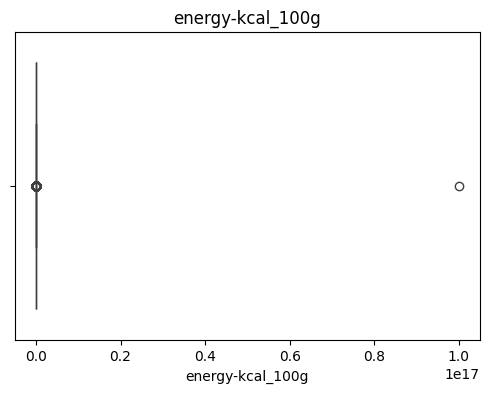

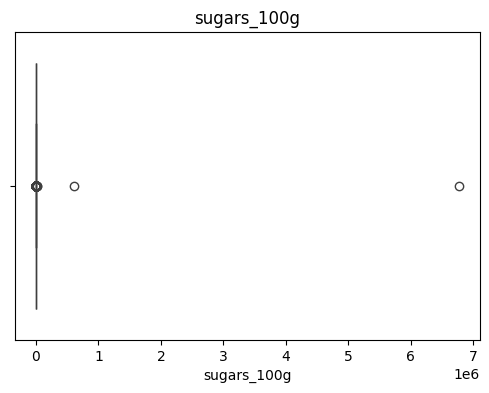

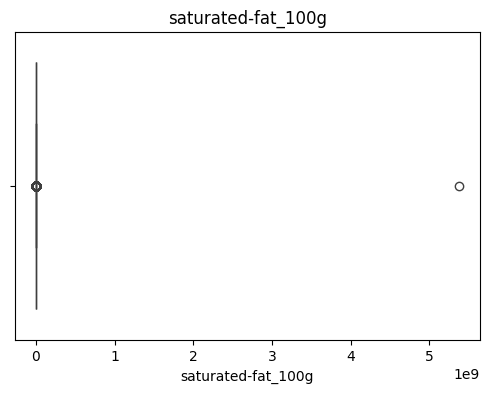

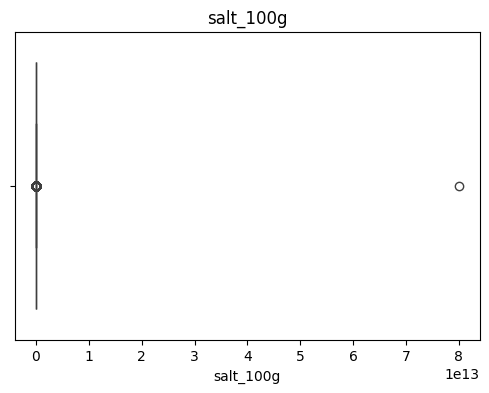

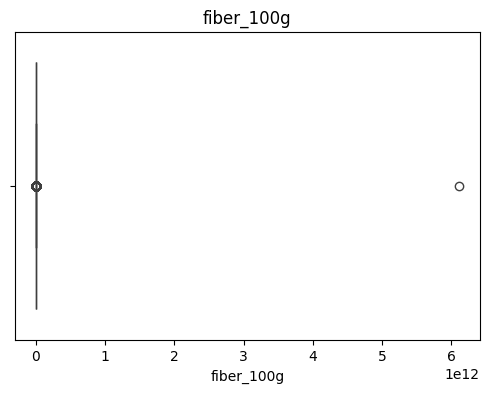

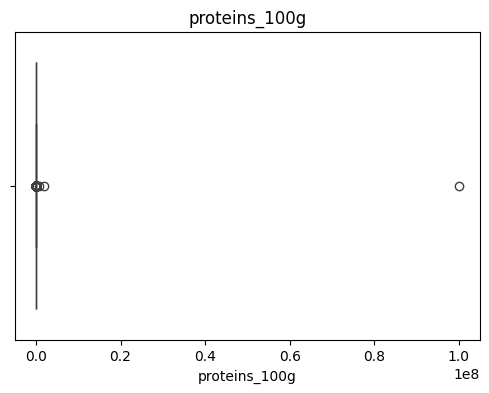

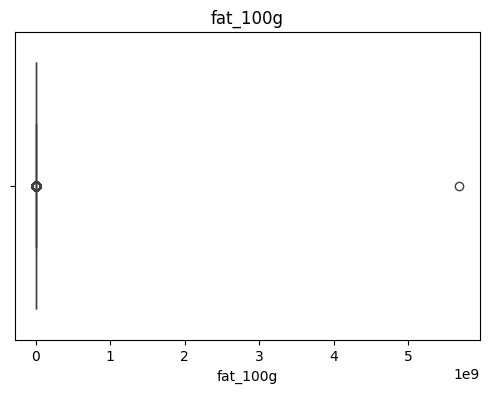

In [69]:
for column in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.show()

In [70]:
len(df)

1119627

##### oczyszczanie danych - pozbycie sie outliers

In [71]:
def remove_outliers(df, numerical_columns):

    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

df_no_outliers = remove_outliers(df, numerical_columns)

In [72]:
len(df_no_outliers)

767737

In [73]:
df_no_outliers["nutriscore_grade"].value_counts()

nutriscore_grade
unknown    286788
c          130818
d          116119
a           94114
e           73175
b           66723
Name: count, dtype: int64

#### Wizualizacje danych

##### Macierz korelacji

<Axes: >

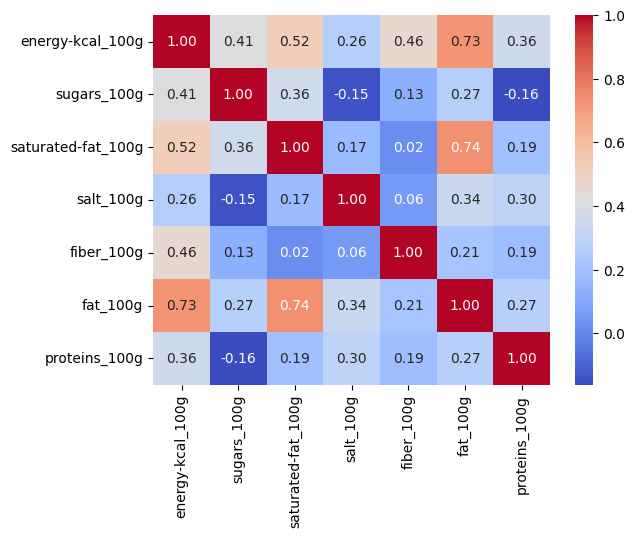

In [74]:
corr = df_no_outliers[["energy-kcal_100g", "sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g", "fat_100g", "proteins_100g"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

##### Boxploty

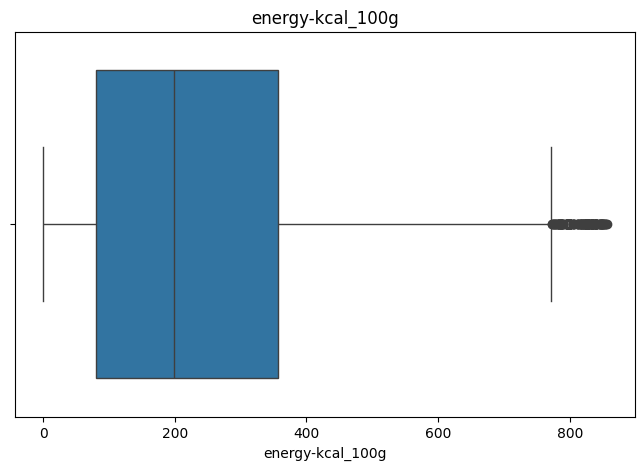

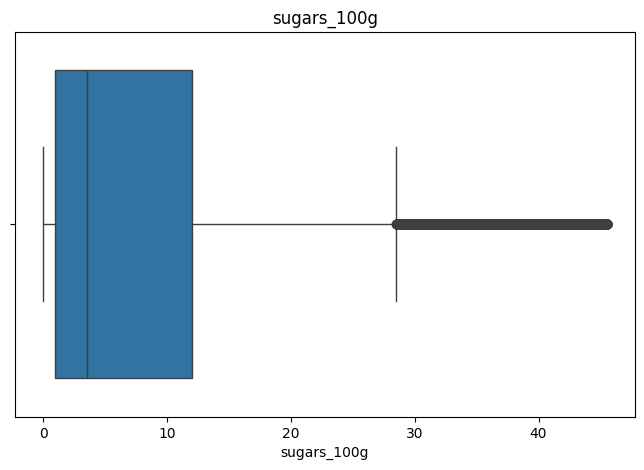

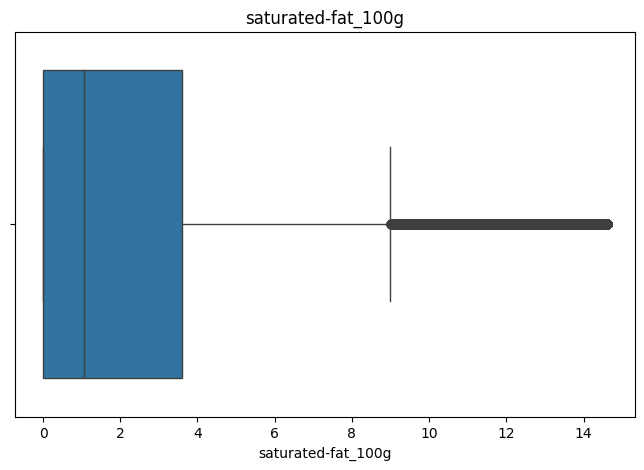

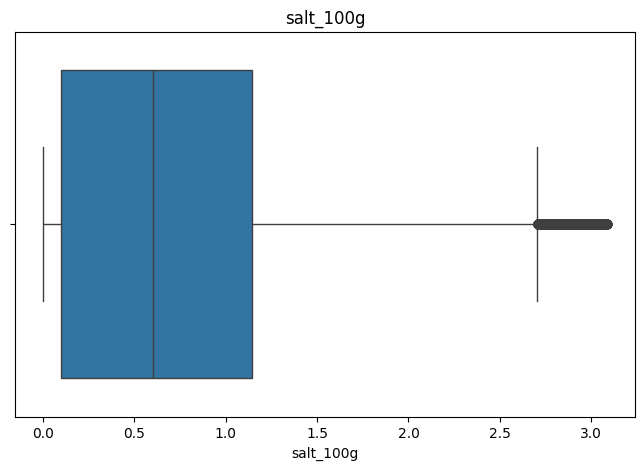

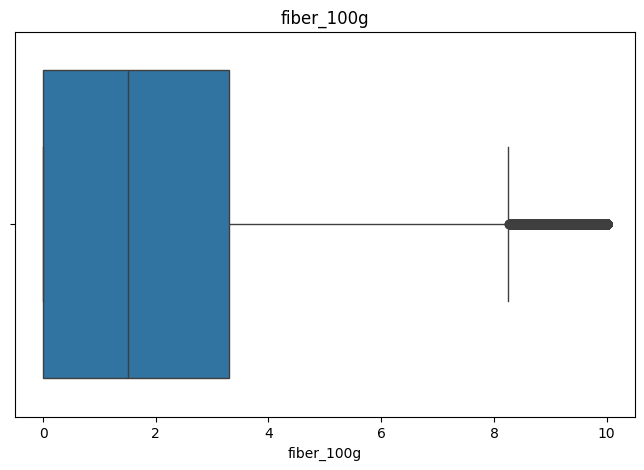

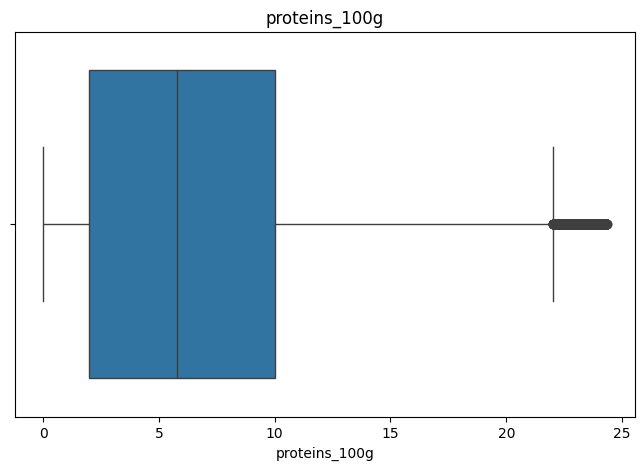

In [75]:
for column in df_no_outliers[["energy-kcal_100g", "sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g", "proteins_100g"]]:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_no_outliers[column])
    plt.title(column)
    plt.show()    

In [76]:
df_no_outliers[["product_name", "categories_en", "ingredients_text", "food_groups_en", "main_category_en", "countries_en", "nutriscore_grade"]].nunique()

product_name        502928
categories_en        57478
ingredients_text    332885
food_groups_en          45
main_category_en     22785
countries_en            95
nutriscore_grade         6
dtype: int64

##### Rozkład produktów per nutri-score

/var/folders/42/qb5wjq2s2tbb78brl4w4mbgh0000gn/T/ipykernel_2315/3865876184.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="nutriscore_grade", data=df_no_outliers, palette="BuPu", order=order)


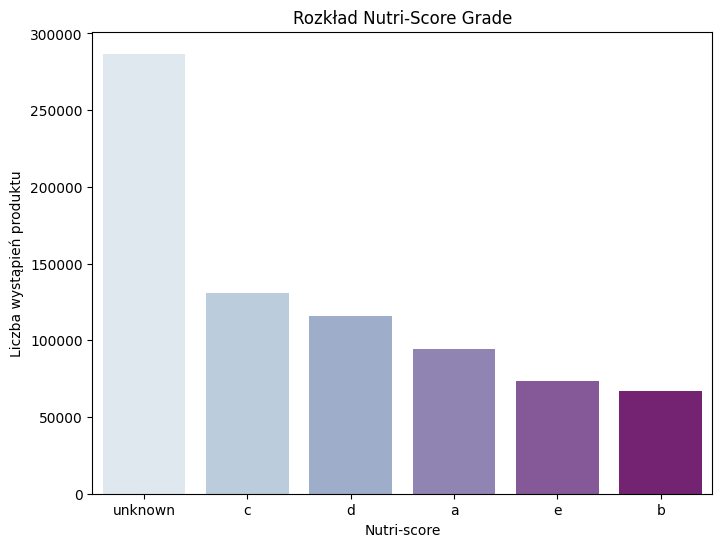

In [77]:
order = df_no_outliers["nutriscore_grade"].value_counts().index

plt.figure(figsize=(8, 6))
sns.countplot(x="nutriscore_grade", data=df_no_outliers, palette="BuPu", order=order)
plt.title("Rozkład Nutri-Score Grade")
plt.xlabel("Nutri-score")
plt.ylabel("Liczba wystąpień produktu")
plt.show()


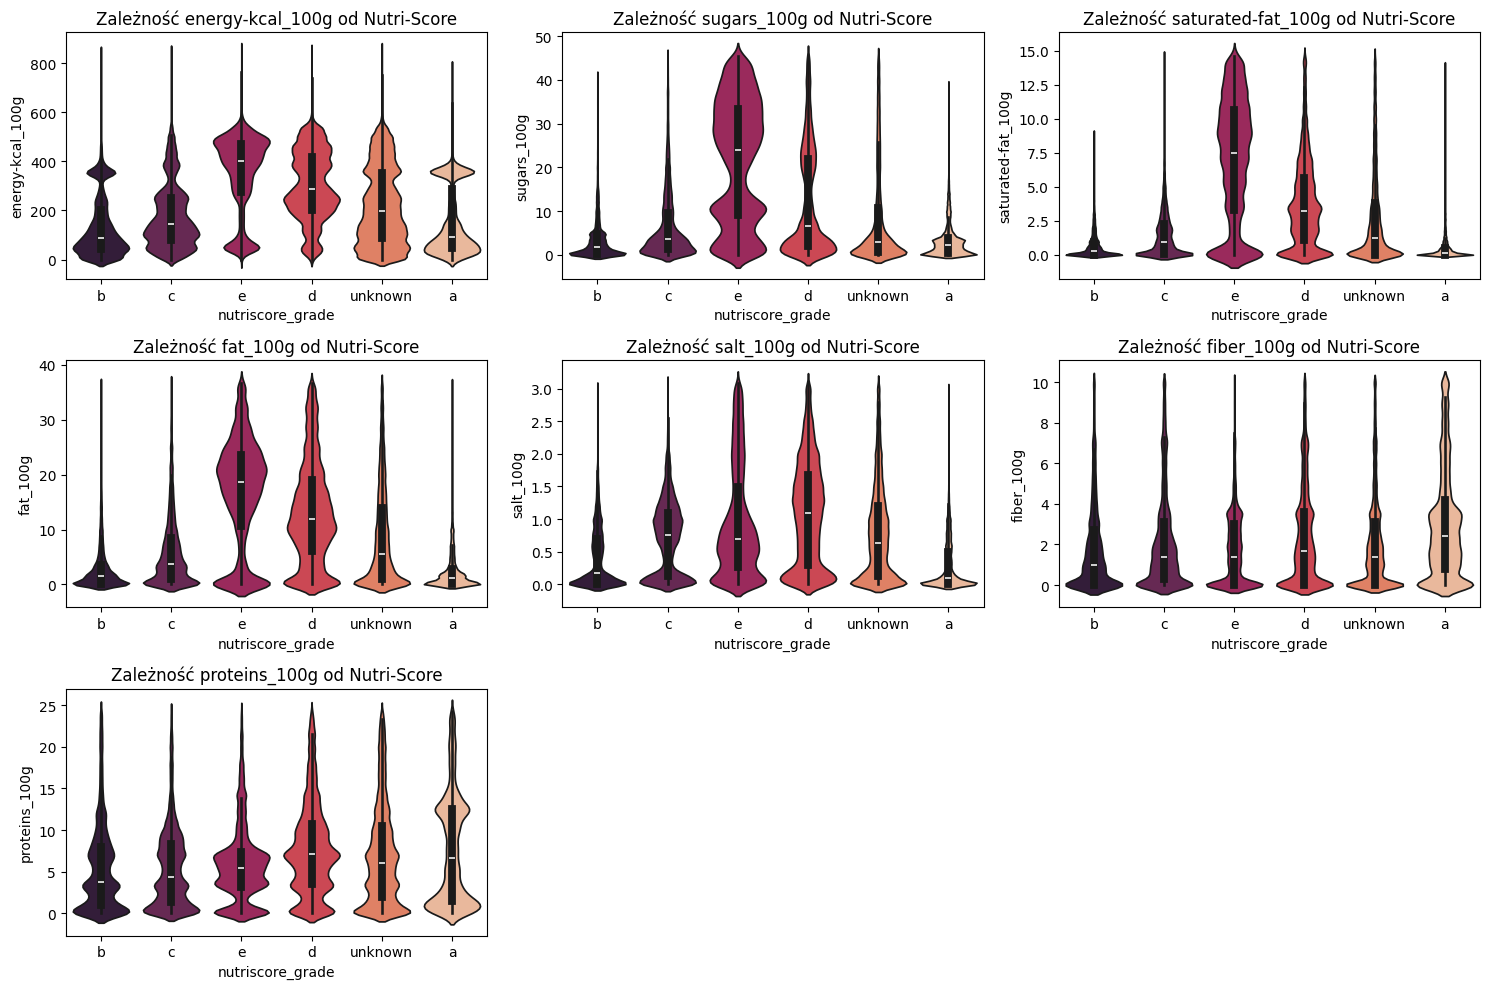

In [78]:
numeric_columns = df_no_outliers.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))  

ncols = 3 
nrows = (len(numeric_columns) // ncols) + (len(numeric_columns) % ncols > 0)

for i, col in enumerate(numeric_columns):
    plt.subplot(nrows, ncols, i + 1)
    sns.violinplot(x='nutriscore_grade', y=col, data=df_no_outliers, hue ='nutriscore_grade',  palette="rocket")
    plt.title(f'Zależność {col} od Nutri-Score')

plt.tight_layout()
plt.show()

In [79]:
df_no_outliers_unknown = df_no_outliers[df_no_outliers["nutriscore_grade"] == "unknown"]

In [80]:
df_no_outliers_unknown.to_csv("../processed_data/openfoodfacts_unknown_nutriscore.csv", index=False)

In [81]:
df_no_outliers_train = df_no_outliers[df_no_outliers["nutriscore_grade"] != "unknown"]
df_no_outliers_train.to_csv("../processed_data/openfoodfacts_processed.csv", index=False)